In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets, tree
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.group = len(np.unique(y))
        self.train = np.hstack((X, y.reshape(len(y), 1)))

    def predict(self, X):
        answers = np.array([], int)
        n_y = len(self.train[0]) - 1
        for i in range(len(X)):
            test1 = sorted(self.train, key=lambda p: euclidean(p[:n_y], X[i]))
            test2 = np.array(test1, int)[:self.n_neighbors, n_y]
            test3 = np.zeros(self.group)
            for j in test2:
                test3[j] += 1
            answers = np.append(answers, test3.argmax())
        return answers


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.group = len(np.unique(y))
            self.x_train = X
            self.y_train = y
        elif self.algorithm == 'kd_tree':
            pass

    def predict(self, X):
        answers = np.array([], int)
        if self.algorithm == 'brute':
            for i in range(len(X)):
                test1 = np.linalg.norm(self.x_train - X[i], axis=1)
                test2 = test1.argsort()[:self.n_neighbors]
                test3 = np.zeros(self.group)
                for j in test2:
                    test3[self.y_train[j]] += 1
                answers = np.append(answers, test3.argmax())
        elif self.algorithm == 'kd_tree':
            pass
        return answers


In [9]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [10]:
%time clf.fit(X_train, y_train)

Wall time: 996 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [11]:
%time my_clf.fit(X_train, y_train)

Wall time: 1e+03 µs


In [12]:
%time clf.predict(X_test)

Wall time: 4.99 ms


array([0, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2, 1])

In [13]:
%time my_clf.predict(X_test)

Wall time: 2.99 ms


array([0, 0, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2, 0, 2, 1], dtype=int64)

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [14]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [15]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [17]:
text = CountVectorizer(data, min_df=100)
vect_text = text.fit_transform(data)
matrix_text = vect_text.toarray()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [18]:
cross_val_score(MyKNeighborsClassifier(n_neighbors=2, algorithm='brute'), matrix_text,
                        target, scoring='accuracy', cv=3, n_jobs=-1)

array([0.128579  , 0.12410501, 0.13497746])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

9


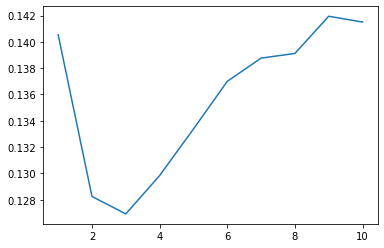

In [19]:
def optimum(k):
    accuracy = np.array([])
    for i in range(1, k+1):
        accur = cross_val_score(KNeighborsClassifier(n_neighbors=i, algorithm='brute'),
                                matrix_text, target, cv=3, n_jobs=-1)
        accuracy = np.append(accuracy, accur.mean())
    plt.plot(range(1, k+1), accuracy)
    return accuracy.argmax() + 1

print(optimum(10))

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [20]:
cross_val_score(KNeighborsClassifier(n_neighbors=9, algorithm='brute', metric='cosine'),
                        matrix_text, target, cv=3, n_jobs=-1).mean()

0.16245366234230293

In [21]:
cross_val_score(KNeighborsClassifier(n_neighbors=9, algorithm='brute'),
                        matrix_text, target, cv=3, n_jobs=-1).mean()

0.14194808588810873

Получили, что точность модели с косинусной метрикой больше на валидации, чем точность модели с евклидовой метрикой.

In [23]:
train_text = TfidfVectorizer(data, min_df=100)
vect_train = train_text.fit_transform(data)
matrix_train = vect_train.toarray()

In [24]:
cross_val_score(KNeighborsClassifier(n_neighbors=9, algorithm='brute'),
                        matrix_train, target, cv=3, n_jobs=-1).mean()

0.16095002896001082

In [25]:
cross_val_score(KNeighborsClassifier(n_neighbors=9, algorithm='brute', metric='cosine'),
                        matrix_train, target, cv=3, n_jobs=-1).mean()

0.4224848682888959

После использования TfIdf векторизации точность увеличивается еще больше. Как видно по качеству на валидации, самая лучшая модель получилась с использованием косинусной метрики и TfIdf векторизации. Ее и используем далее.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [32]:
group = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data = group['data']
target = group['target']
test_text = TfidfVectorizer(data, min_df=100)
vect_test = test_text.fit_transform(data)
matrix_test = vect_test.toarray()

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [33]:
cross_val_score(KNeighborsClassifier(n_neighbors=9, algorithm='brute', metric='cosine'),
                        matrix_test, target, cv=3, n_jobs=-1).mean()

0.3629841711079484

Качество на test части меньше, чем на train.
Так получилось ввиду того, что слова из выборок могли отличаться.